In [7]:
import numpy as np
import pandas as pd
from keras.utils import to_categorical

## Step 1: Preparing Data

In [8]:
# define all the constant
filepath = './data/fer20131.csv'
names = ['emotions', 'pixels', 'usage']
usages = ['Training', 'PublicTest', 'PrivateTest']
emotion_label = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']


In [9]:
# function that load csv data in fer2013
def load_data(usage, names):
    data = pd.read_csv(filepath, names=names)
    data = data[data.usage == usage]
    # print(data.shape)
    # get x_train and y_train
    pixel_list = list(data['pixels'])
    emotion_list = list(data['emotions'])
    X = []
    Y = []
    for i in range(1,len(pixel_list)):
        X.append([int(x) for x in pixel_list[i].split()])
    for i in range(1, len(emotion_list)):
        Y.append(int(emotion_list[i]))
    X = np.array(X).reshape(len(X), 48, 48, 1)
    Y = np.array(Y)
    return X, Y


In [10]:
# function that save data
def save_data(data_x, data_y, suffix):
    np.save('./data/x_' + suffix, data_x)
    np.save('./data/y_' + suffix, data_y)

In [6]:
# load test, train and evaluate data
test_x, test_y = load_data(usages[1], names)
train_x, train_y = load_data(usages[0], names)
eval_x, eval_y = load_data(usages[2], names)

KeyboardInterrupt: 

In [113]:
# use one-hot encoding
test_y = to_categorical(test_y, 7)
train_y = to_categorical(train_y, 7)
eval_y = to_categorical(eval_y, 7)

In [114]:
# save all the data in .npy for future use
save_data(test_x, test_y, 'test')
save_data(eval_x, eval_y, 'eval')
save_data(train_x, train_y, 'train')

In [11]:
# training data set
x_train = np.load('./data/x_train.npy')/255
y_train = np.load('./data/y_train.npy')

# testing data set
x_test = np.load('./data/x_test.npy')/255
y_test = np.load('./data/y_test.npy')

# evaluating data set
x_eval = np.load('./data/x_eval.npy')/255
y_eval = np.load('./data/y_eval.npy')

In [68]:
# check shapes
print(x_train.shape)
print(x_test.shape)
print(x_eval.shape)

print('-------------')

print(y_train.shape)
print(y_test.shape)
print(y_eval.shape)


(28708, 48, 48, 1)
(3588, 48, 48, 1)
(3588, 48, 48, 1)
-------------
(28708, 7)
(3588, 7)
(3588, 7)


### Preview of the images

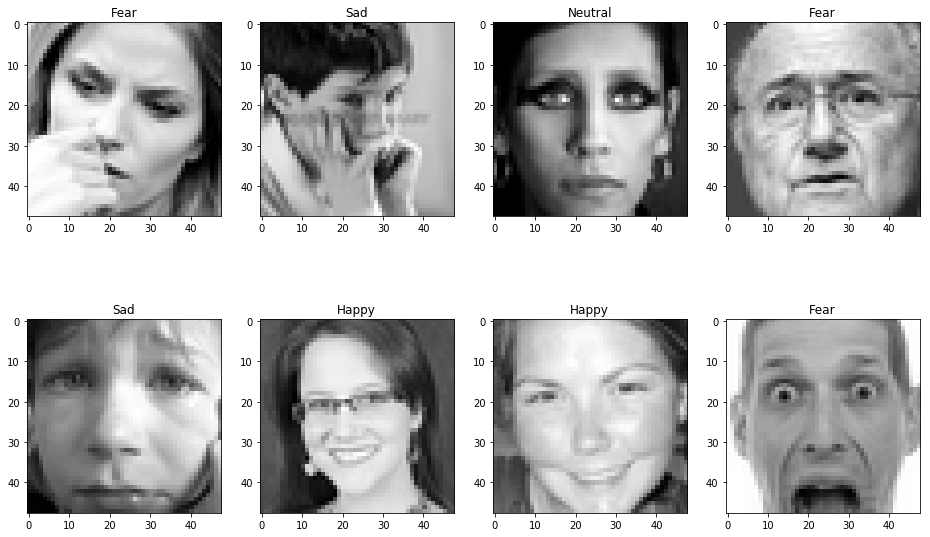

In [62]:
import matplotlib.pyplot as plt

img_number = 9
show_image = (x_train * 255)[:img_number].reshape((img_number, 48, 48))
plt.figure(figsize=(16,10))

# take a look at the first 8 images from the training set
for i in range(1, img_number):
    index = int(np.argwhere(y_train[i]==1))
    plt.subplot(2, 4, i)
    plt.title(emotion_label[index])
    plt.imshow(show_image[i], cmap='gray')



## Step 2: Building a CNN

In [84]:
from keras import models
from keras import layers
from keras import optimizers
from keras.losses import categorical_crossentropy
from keras.layers.convolutional import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

In [271]:
input_size = (48, 48, 1)

model = models.Sequential()

# modulue 1
model.add(layers.Conv2D(32, (3,3), padding='same', input_shape=input_size))
model.add(layers.normalization.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(32, (3,3), padding='same'))
model.add(layers.normalization.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2, 2)))

# modulue 2
model.add(layers.Conv2D(64, (3,3), padding='same'))
model.add(layers.normalization.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(64, (3,3), padding='same'))
model.add(layers.normalization.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2, 2)))


# modulue 3
model.add(layers.Conv2D(128, (3,3), padding='same'))
model.add(layers.normalization.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(128, (3,3), padding='same'))
model.add(layers.normalization.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2, 2)))


# adding dense connected neural network

# Dense 1
model.add(layers.Flatten())
model.add(layers.Dense(128))
model.add(layers.normalization.BatchNormalization())
model.add(layers.Activation('relu'))

# Dense 2
model.add(layers.Dense(64))
model.add(layers.normalization.BatchNormalization())
model.add(layers.Activation('relu'))


# Dense 3
model.add(layers.Dense(32))
model.add(layers.normalization.BatchNormalization())
model.add(layers.Activation('relu'))


# output using softmax
model.add(layers.Dense(len(emotion_label), activation='softmax'))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
batch_normalization_80 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
activation_80 (Activation)   (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 48, 48, 32)        9248      
_________________________________________________________________
batch_normalization_81 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
activation_81 (Activation)   (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 24, 24, 32)        0         
__________

In [272]:
# generate the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [273]:
nb_epoch = 20
batch_size = 128

# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)


es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

history = model.fit_generator(data_generator.flow(x_train, y_train, batch_size),
                                steps_per_epoch=len(x_train) / batch_size,
                                epochs=nb_epoch,
                                verbose=1, 
                                callbacks = [es],
                                validation_data=(x_eval, y_eval))


Epoch 1/20
225/224 [==============================] - 336s 1s/step - loss: 1.6840 - acc: 0.3356 - val_loss: 1.6156 - val_acc: 0.3710
Epoch 2/20
225/224 [==============================] - 310s 1s/step - loss: 1.4046 - acc: 0.4573 - val_loss: 1.3777 - val_acc: 0.4810
Epoch 3/20
225/224 [==============================] - 330s 1s/step - loss: 1.2690 - acc: 0.5150 - val_loss: 1.2711 - val_acc: 0.5173
Epoch 4/20
225/224 [==============================] - 303s 1s/step - loss: 1.1923 - acc: 0.5453 - val_loss: 1.2051 - val_acc: 0.5348
Epoch 5/20
225/224 [==============================] - 300s 1s/step - loss: 1.1400 - acc: 0.5646 - val_loss: 1.1571 - val_acc: 0.5571
Epoch 6/20
225/224 [==============================] - 300s 1s/step - loss: 1.1009 - acc: 0.5839 - val_loss: 1.1484 - val_acc: 0.5602
Epoch 7/20
225/224 [==============================] - 301s 1s/step - loss: 1.0689 - acc: 0.5938 - val_loss: 1.0734 - val_acc: 0.5808
Epoch 8/20
225/224 [==============================] - 328s 1s/step - 

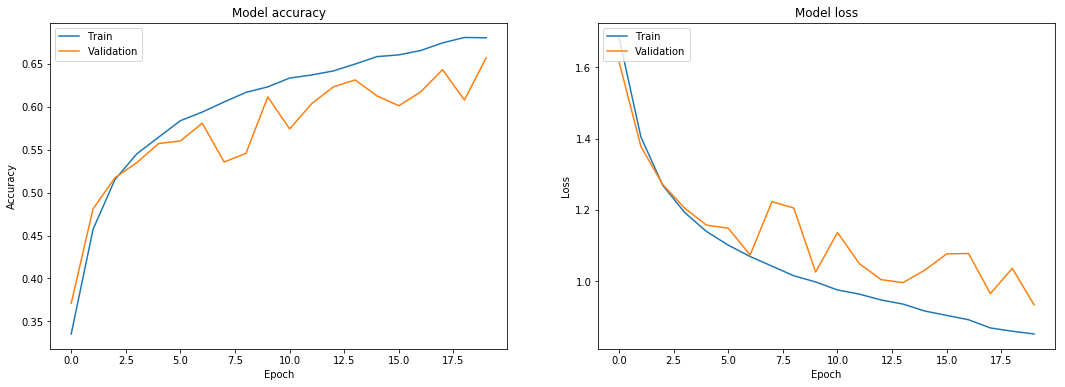

In [274]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history.history['acc'])
axes[0].plot(history.history['val_acc'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [275]:
model.save('facial-emotion-model-accuracy-65')

In [276]:
from sklearn.metrics import accuracy_score
test_true = np.argmax(y_test, axis=1)
test_result = np.argmax(model.predict(x_test),axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_result)))

CNN Model Accuracy on test set: 0.6410


## visualize cnn processing data

(1, 48, 48, 1)


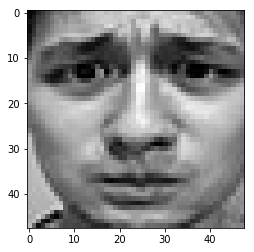

In [281]:
# demo image
from keras.preprocessing import image

img = image.load_img('./data/demo_sad.jpg', target_size=(48, 48))
img_tensor = image.img_to_array(img)

img_tensor = img_tensor[:48,:48,:1].reshape(1, 48, 48, 1)

# img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.



print(img_tensor.shape)
plt.imshow(img_tensor[0].reshape(48, 48), cmap='gray')

(1, 48, 48, 1)


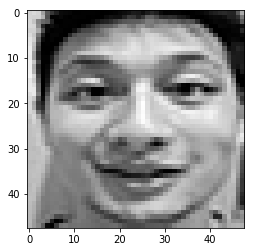

In [286]:
# demo image
from keras.preprocessing import image

# load and convert the img to grey scale
img = image.load_img('./data/demo_happy.jpg', target_size=(48, 48))
img_tensor = image.img_to_array(img)
img_tensor = img_tensor[:48,:48,:1].reshape(1, 48, 48, 1)

# img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.



print(img_tensor.shape)
plt.imshow(img_tensor[0].reshape(48,48), cmap='gray')

The model predict the picture to be Happy


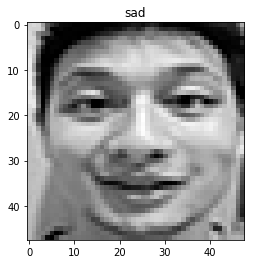

In [287]:
layer_output = [layer.output for layer in model.layers[:20]]
activation_model = models.Model(inputs=model.input, outputs=layer_output)
activations = activation_model.predict(img_tensor)

# display the picture and the predicted result
plt.imshow(img_tensor.reshape(48, 48), cmap='gray')
plt.title('sad')

predict_result = np.argmax(model.predict(img_tensor))
print('The model predict the picture to be {}'.format(emotion_label[predict_result]))

The model predict the picture to be Happy


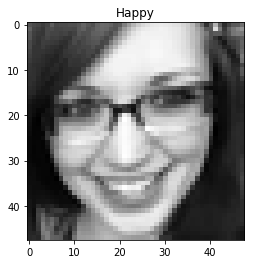

In [285]:
chosen_picture_index = 3

layer_output = [layer.output for layer in model.layers[:23]]
activation_model = models.Model(inputs=model.input, outputs=layer_output)
activations = activation_model.predict(x_test[chosen_picture_index].reshape(1, 48, 48, 1))

# display the picture and the predicted result
plt.imshow(x_test[chosen_picture_index].reshape(48, 48), cmap='gray')
plt.title(emotion_label[int(np.argwhere(y_test[chosen_picture_index]))])

predict_result = np.argmax(model.predict(x_test[chosen_picture_index].reshape(1, 48, 48, 1)))
print('The model predict the picture to be {}'.format(emotion_label[predict_result]))

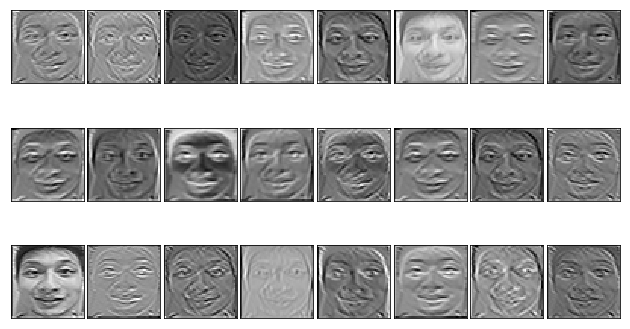

In [293]:
# First Conv2d
first_layer_activation = activations[0]

fig, axes = plt.subplots(3, 8, figsize=(9, 6), subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(left=0.03, right=0.97, hspace=0.3, wspace=0.05)

# print(axes.flat)

for index in range(len(axes.flat)):
    axes.flat[index].imshow(first_layer_activation[0,:,:, index], cmap='gray')
    

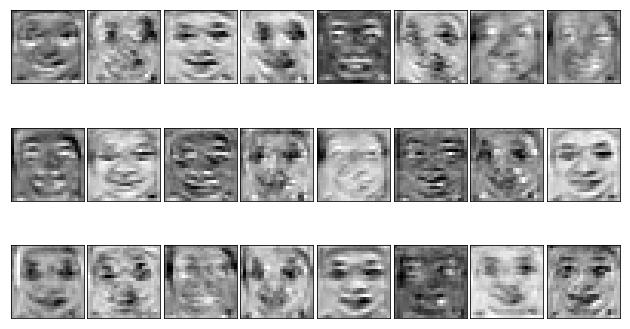

In [289]:
# third Conv2d
first_layer_activation = activations[7]

fig, axes = plt.subplots(3, 8, figsize=(9, 6), subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(left=0.03, right=0.97, hspace=0.3, wspace=0.05)

# print(axes.flat)

for index in range(len(axes.flat)):
    axes.flat[index].imshow(first_layer_activation[0,:,:, index], cmap='gray')